In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import yaml
import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive
import ipywidgets as widgets

In [2]:
# Nice BioLector
#attributes = ['M', 'A01', 'X1', '', '1', '[1] Biomass-Gain2 Gain=2']
#for attr in enumerate(attributes):
#    print(attr)
#print('\n')
# Mean BioLector
#attributes = ['A01','X27','TB, E.coli','1']
#for attr in enumerate(attributes):
#    print(attr)

In [1]:
def pullFile(infile):
    with open(infile, "r") as f:
        DATA = []
        GAIN = []
        WellL, WellN = [], []
        TIME, already = [[]], False
        for line in f:
            val = re.split(';',line)
            if val[0] == 'M':
                # creat empty list for data
                temp = []
                # populate the list
                for obs in val[6:-1]:
                    temp.append(float(obs))
                # append data to output data list
                DATA.append(temp)
                GAIN.append(int(val[5][-1]))
                WellL.append(val[1][0])
                WellN.append(int(val[1][2]))
                
            if len(val[0]) == 3:
                if (val[0][0] in ['A','B','C','D','E','F'] and val[0][1] == '0' and (val[3] in ['1','2'])):
                    # creat empty list for data
                    temp = []
                    # populate the list
                    for obs in val[4:-1]:
                        temp.append(float(obs))
                    # append data to output data list
                    DATA.append(temp)
                    GAIN.append(int(val[3]))
                    WellL.append(val[0][0])
                    WellN.append(int(val[0][2]))
                    
            if val[0] == 'T' and already == False:
                for time in val[6:-1]:
                    TIME[0].append(float(time))
                already = True
            if len(val) > 3:
                if val[3] == 'TIME [h] ->' and already == False:
                    for time in val[4:-1]:
                        TIME[0].append(float(time))
                    already = True

        TIME = TIME * (len(DATA))
        TIME = np.array(TIME)
        WellL = np.array(WellL)
        WellN = np.array(WellN)
        GAIN = np.array(GAIN)
        DATA = np.array(DATA)
        
    # Organize data by attributes and create masks
    gList = sorted(set(GAIN))
    gMask = {}
    for g in gList:
        gMask[g] = (GAIN == g)
    #print(f"Gains : {gList}")

    wlList = sorted(set(WellL))
    wlMask = {}
    for l in wlList:
        wlMask[l] = (WellL == l)
    #print(f"Well Letters : {wlList}")

    wnList = sorted(set(WellN))
    wnMask = {}
    for n in wnList:
        wnMask[n] = (WellN == n)
    #print(f"Well Numbers : {wnList}")
    
    return(DATA,TIME,wlMask,wnMask,gMask)

def subBlank(data,snsData,datMask,blankMask):
    rawBlank = data[blankMask]
    blankData = np.mean(rawBlank, axis=0)
    blank = blankData.tolist()
    blank = blank * int(snsData.shape[0]/blankData.shape[0])
    blank = np.array(blank)
    newDat = snsData - blank
    return(newDat)
    
def snsPrep(data,time,mask):
    plotData = data[mask].transpose()
    plotData = plotData.reshape(plotData.shape[0]*plotData.shape[1],1)
    plotTime = time[mask].transpose()
    plotTime = plotTime.reshape(plotTime.shape[0]*plotTime.shape[1],1)
    return(plotData,plotTime)

def readConf(inYaml,wlMask,wnMask,gMask):
    # Read in Configuration data
    InData, DatMasks, DatLabels = [], [], []
    with open(inYaml, 'r') as file:
        docs = yaml.safe_load_all(file)
        for doc in docs:
            InData.append(doc)
    # Loop through systems creating masks for the data and corresponding blanks       
    for sys in InData:
        
        datWell = wnMask[sys['Well-N'][0]]
        for i in sys['Well-N']:
            datWell = datWell | wnMask[i]
            
        datLet = wlMask[sys['Well-L'][0]]
        for i in sys['Well-L']:
            datLet = datLet | wlMask[i]
        
        blankWell = wnMask[sys['Blank-N'][0]]
        for i in sys['Blank-N']:
            blankWell = blankWell | wnMask[i]
            
        blankLet = wlMask[sys['Blank-L'][0]]
        for i in sys['Blank-L']:
            blankLet = blankLet | wlMask[i]
        
        gain = gMask[sys['Gain']]
        
        DatMasks.append([datLet & datWell & gain, blankLet & blankWell & gain])
        DatLabels.append(sys['Name'])
    return(DatMasks,DatLabels)

def dataPrep(infile,inYaml):
    # Collect data from file
    DATA,TIME,wlMask,wnMask,gMask = pullFile(infile)
    # Group the Collected Data
    SysMasks, SysLabels = readConf(inYaml,wlMask,wnMask,gMask)
    return(DATA,TIME,SysMasks,SysLabels)

def dataPlot(DATA,TIME,masks,labels,xl='Time (h)',yl='Biomass (A.U.)',lw=2):
    plt.clf()
    plt.rcParams.update({'font.size': 20})
    for lab in enumerate(labels):
        print(lab)
    choice = input("Which Strains? ")
    choice = choice.split(',')
    colorchoice = input("Which Colours? ")
    colorchoice = colorchoice.split(',')
    Fig, ax = plt.subplots(1,1,figsize=(10,5))
    for i,c in zip(choice,colorchoice):
        i = int(i)
        plotData, plotTime = snsPrep(DATA,TIME,masks[i][0])
        plotData = subBlank(DATA,plotData,masks[i][0],masks[i][1])
        sns.lineplot(x=plotTime[:,0],y=plotData[:,0],label=labels[i],ax=ax,color=c,linewidth=lw)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
    save = bool(int(input("Save image? 0 = no, 1 = yes\n")))
    if save == True:
        outname = str(input("Name of file? "))
        Fig.savefig(f"./{outname}.png",dpi=300,transparent=False)
        
def FindRateMean(xmin,xmax,Strain):
    time = TIME[0][xmin:xmax].reshape(-1,1)
    data = np.mean(DATA[SysMasks[Strain][0]],axis=0)[xmin:xmax]
    linreg = LinearRegression().fit(time, data)
    r_sq = linreg.score(time, data)
    newline = linreg.predict(time)
    Fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(TIME[0],np.mean(DATA[SysMasks[Strain][0]],axis=0))
    ax[0].plot(time,newline,linewidth=3,c='red',label=(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f}"))
    ax[1].scatter(x=time,y=data)
    ax[1].plot(time,newline,linewidth=3,c='red',label=(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f}"))
    #plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel("Time (h)")
    plt.ylabel("BioMass (A.U.)")
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    plt.tight_layout()
    print(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f} \nTd = {np.log(2)/linreg.coef_[0]}")
    print(f"Strain: {SysLabels[Strain]}")
    
def FindRateLog(xmin,xmax,Strain):
    def logf(x,A,B):
        return A * np.exp(B * x)
    time = TIME[0][xmin:xmax]
    data = np.mean(DATA[SysMasks[Strain][0]],axis=0)[xmin:xmax]
    popt, pcov = curve_fit(logf, time, data)
    Fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(TIME[0],np.mean(DATA[SysMasks[Strain][0]],axis=0))
    ax[0].plot(time,logf(time, *popt),linewidth=3,c='red',label=(f"boogers"))
    ax[0].set_yscale("log")
    ax[1].scatter(x=time,y=data)
    ax[1].plot(time,logf(time, *popt),linewidth=3,c='red',label=(f"boogers"))
    ax[1].set_yscale("log")
    plt.tight_layout()
    print(f"Rate: {popt[1]:.2f}")
    print(f"Doubling Time: {np.log(2)/popt[1]:.2f} hr")
    print(f"Strain: {SysLabels[Strain]}")
    
def FindRateRaw(xmin,xmax,Strain):
    def logf(x,A,B):
        return A * np.exp(B * x)
    time = TIME[0][xmin:xmax]
    data = DATA[SysMasks[Strain][0]]
    rate, Td = [], []
    for dat in data:
        data = dat
        dat = dat[xmin:xmax]
        popt, pcov = curve_fit(logf, time, dat)
        plt.plot(TIME[0],data)
        plt.plot(time,logf(time, *popt),linewidth=3,c='red',label=(f"rate = {popt[1]:.3f}"))
        rate.append(popt[1])
        Td.append(np.log(2)/popt[1])
    print(f"Avg. Rate {np.mean(rate):.3f} ({np.std(rate):.3f})\n")
    print(f"Avg. Td   {np.mean(Td):.3f} ({np.std(Td):.3f})\n")
    #plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel("Time (h)")
    plt.ylabel("Biomass (A.U.)")
    print(f"Strain: {SysLabels[Strain]}")
    
def saveRate(xmin,xmax,Strain):
    outname = str(input("Choose output name. "))
    time = TIME[0][xmin:xmax].reshape(-1,1)
    data = np.mean(DATA[SysMasks[Strain][0]],axis=0)[xmin:xmax]
    linreg = LinearRegression().fit(time, data)
    r_sq = linreg.score(time, data)
    newline = linreg.predict(time)
    Fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].plot(TIME[0],np.mean(DATA[SysMasks[Strain][0]],axis=0))
    ax[0].plot(time,newline,linewidth=3,c='red',label=(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f}"))
    ax[1].scatter(x=time,y=data)
    ax[1].plot(time,newline,linewidth=3,c='red',label=(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f}"))
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel("Time (h)")
    plt.ylabel("BioMass (A.U.)")
    plt.yscale("log")
    plt.tight_layout()
    print(f"rate = {linreg.coef_[0]:.3f} A.U./hr\nr^2 = {r_sq:.3f}")
    print(f"Strain: {SysLabels[Strain]}")
    plt.savefig(f"{outname}.png",dpi=300)

# Run Data-Prep

In [92]:
DATA, TIME, SysMasks, SysLabels = dataPrep('./205_Susana_growth_gain2.csv','./205_Susana_growth_gain2.yml')
#DATA, TIME, SysMasks, SysLabels = dataPrep('./susana-OD_20220526_142639_TRANSFORM_CALIBIOMASS.csv','./susana-OD_20220526_142639_TRANSFORM_CALIBIOMASS.yml')

# Run Data-Plot

(0, 'MB001(DE3) pMKEx3 (ethanol)')
(1, 'MB001(DE3) pMKEx3 (glucose)')
(2, 'MB001(DE3) pMKEx3_DzAda (ethanol)')
(3, 'MB001(DE3) pMKEx3_DzAda (glucose)')
(4, 'MB001(DE3)Δcg3096 pMKEx3 (ethanol)')
(5, 'MB001(DE3)Δcg3096 pMKEx3 (glucose)')
(6, 'MB001(DE3)Δcg3096 pMKEx3_Cg3096 (ethanol)')
(7, 'MB001(DE3)Δcg3096 pMKEx3_Cg3096 (glucose)')
(8, 'MB001(DE3)Δcg3096 pMKEx3_DzAda (ethanol)')
(9, 'MB001(DE3)Δcg3096 pMKEx3_DzAda (glucose)')
(10, 'MB001(DE3)Δcg3096 pMKEx3_Cg3096 100µM IPTG')
(11, 'MB001(DE3)Δcg3096 pMKEx3_DzAda 100µM IPTG')
Which Strains? 0,1,2
Which Colours? blue,white,green


<Figure size 432x288 with 0 Axes>

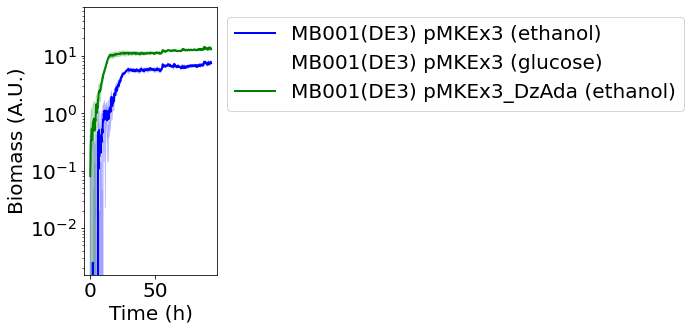

Save image? 0 = no, 1 = yes
0


In [6]:
DATA, TIME, SysMasks, SysLabels = dataPrep('./205_Susana_growth_gain2.csv','./205_Susana_growth_gain2.yml')
dataPlot(DATA,TIME,SysMasks,SysLabels)

# Find Rates

In [108]:
interactive(FindRateLog, xmin = (0,len(TIME[0]),1), xmax = (15,len(TIME[0]),1), Strain = (0,len(SysMasks)-1,1))

interactive(children=(IntSlider(value=187, description='xmin', max=375), IntSlider(value=195, description='xma…

In [106]:
interact(FindRateRaw, xmin = (0,len(TIME[0]),1), xmax = (5,len(TIME[0]),1), Strain = (0,len(SysMasks)-1,1))

interactive(children=(IntSlider(value=187, description='xmin', max=375), IntSlider(value=190, description='xma…

<function __main__.FindRateRaw(xmin, xmax, Strain)>

# Experiment 20220608

In [ ]:
DATA, TIME, SysMasks, SysLabels = dataPrep('./susana-OD_20220526_142639_TRANSFORM_CALIBIOMASS.csv','./susana-OD_20220526_142639_TRANSFORM_CALIBIOMASS.yml')

In [7]:
def barPlot(DATA,TIME,masks,labels,xl='Strains',yl='Biomass (A.U.)',lw=2):
    def barPrep(data,time,mask):
        plotData = data[mask]
        barData = plotData[:,-1]
        barData = np.array(barData)
        return(barData)
    plt.clf()
    plt.rcParams.update({'font.size': 20})
    for lab in enumerate(labels):
        print(lab)
    choice = input("Which Strains? ")
    choice = choice.split(',')
    colorchoice = input("Which Colours? ")
    colorchoice = colorchoice.split(',')
    Fig, ax = plt.subplots(1,1,figsize=(10,10))
    plotData, plotErr = [], []
    for i,c,n in zip(choice,colorchoice,range(len(choice))):
        i = int(i)
        barData = barPrep(DATA,TIME,masks[i][0])
        barBlank = barPrep(DATA,TIME,masks[i][1])
        plotData = np.mean(barData - barBlank)
        plotErr = np.std(barData - barBlank)
        ax.bar(n,plotData,yerr=plotErr,color=c,label=labels[i])
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.xticks([i for i in range(len(choice))],[i for i in choice])
    plt.yscale("linear")
    #plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
    save = bool(int(input("Save image? 0 = no, 1 = yes\n")))
    if save == True:
        outname = str(input("Name of file? "))
        Fig.savefig(f"./{outname}.png",dpi=300,transparent=False)

In [ ]:
barPlot(DATA,TIME,SysMasks,SysLabels)

In [54]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
DATA
y = logf(xdata, 2.5, 1.3)

In [56]:
DATA.shape

(96, 191)

In [88]:
np.exp(0.8)

2980.9579870417283